# Imports

In [281]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from astropy.table import Table
import scipy.interpolate as interp
import os
import model_flux_ratio as mfr
#from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import matplotlib.backends.backend_pdf

In [3]:
path = os.getcwd()

# Hydrogen Emissivity from NEBULAR, which uses some fit to Storey & Sochi 2015

## Load

In [4]:
hydrogen_emissivities = Table.read('/Users/thsyu/Software/Yp/tables/hydrogen_emissivity_short', format='ascii', delimiter='\t')

In [5]:
hydrogen_emissivities[0:5]

Nu,Nl,log(T),log(ne),emissivity
int64,int64,float64,int64,float64
3,2,2.6,0,5.23576e-24
3,2,2.6,1,5.33661e-24
3,2,2.6,2,5.43941e-24
3,2,2.6,3,5.54418e-24
3,2,2.6,4,5.77077e-24


## Interpolate S&S 2015 emissivities, as in NEBULAR (linear)

This is trying to duplicate the linear interpolation/extrapolation that NEBULAR does on the Storey & Sochi 2015 hydrogen emissivities.

In [25]:
# Find indices in NEBULAR table (including linear extrapolation) corresponding to transitions
ha_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 3)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
hb_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 4)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
hg_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 5)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
hd_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 6)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
heps_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 7)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
h8_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 8)[0], np.where(hydrogen_emissivities['Nl'] == 2)[0])
pg_idx = np.intersect1d(np.where(hydrogen_emissivities['Nu'] == 6)[0], np.where(hydrogen_emissivities['Nl'] == 3)[0])

# Interpolate these
halpha = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[ha_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
hbeta = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[hb_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
hgamma = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[hg_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
hdelta = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[hd_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
hepsilon = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[heps_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
h8 = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[h8_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)
pagamma = interp.RectBivariateSpline(np.linspace(2.6, 4.7, num=22), np.arange(0, 9), hydrogen_emissivities[pg_idx]['emissivity'].reshape(22, 9), kx=1, ky=1)

# Checking these match with the 5 column table hydrogen_emissivity_short
print (halpha(2.6, 0)[0][0])
print (halpha(2.7, 0)[0][0])
print (halpha(2.8, 0)[0][0])
print (halpha(2.9, 0)[0][0])
print (halpha(2.6, 1)[0][0])
print (halpha(2.7, 1)[0][0])
print (halpha(2.8, 1)[0][0])
print (halpha(2.85, 1)[0][0])
print (halpha(2.9, 1)[0][0])

5.23576e-24
4.39661e-24
3.5981300000000035e-24
2.9755500000000027e-24
5.33661e-24
4.48193e-24
3.726040000000003e-24
3.4135750000000014e-24
3.101110000000003e-24


## Set temperature, density for analysis

In [26]:
ne = 100

In [27]:
# Temperature array
temps = 10**np.linspace(2.0, 4.4, num=25) #np.linspace(5e3, 25e3, num=21)
print (temps)

[  100.           125.89254118   158.48931925   199.5262315
   251.18864315   316.22776602   398.10717055   501.18723363
   630.95734448   794.32823472  1000.          1258.92541179
  1584.89319246  1995.26231497  2511.88643151  3162.27766017
  3981.07170553  5011.87233627  6309.5734448   7943.28234724
 10000.         12589.25411794 15848.93192461 19952.62314969
 25118.8643151 ]


## Old, Hummer & Storey 1987 Hydrogen Emissivities

In [28]:
# Old Hummer & Storey 1987 emissivities, relative to H-beta, including C/R
old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne)
old_hg_dens = mfr.hydrogen_emissivity_old(4341, temps, ne) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4341, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
old_hd_dens = mfr.hydrogen_emissivity_old(4102, temps, ne) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4102, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))


In [16]:
ha_dens = np.zeros(len(temps))
hb_dens = np.zeros(len(temps))
hg_dens = np.zeros(len(temps))
hd_dens = np.zeros(len(temps))

for i in range(len(temps)):
    ha_dens[i] = halpha(np.log10(temps[i]), np.log10(ne))[0][0]
    hb_dens[i] = hbeta(np.log10(temps[i]), np.log10(ne))[0][0]
    hg_dens[i] = hgamma(np.log10(temps[i]), np.log10(ne))[0][0]
    hd_dens[i] = hdelta(np.log10(temps[i]), np.log10(ne))[0][0]

### Plots of Hummer & Storey 1987 vs NEBULAR linear extrapolated Emissivities

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


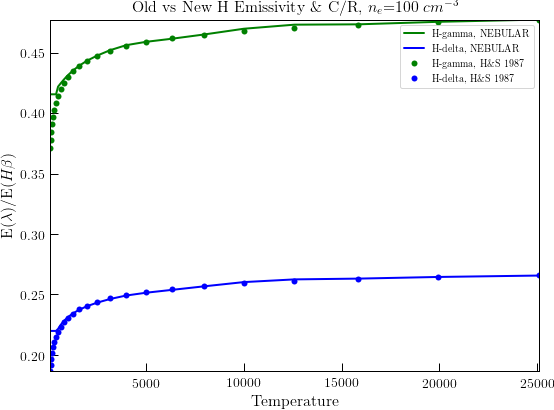

In [23]:
plt.subplots(figsize=(8,6))
#plt.plot(temps, ha_dens/hb_dens, label='H-alpha', color='red')
plt.plot(temps, hg_dens/hb_dens, label='H-gamma, NEBULAR', color='green')
plt.plot(temps, hd_dens/hb_dens, label='H-delta, NEBULAR', color='blue')
#plt.plot(temps, old_ha_dens, 'o', color='red')
plt.plot(temps, old_hg_dens, 'o', label='H-gamma, H\&S 1987', color='green')
plt.plot(temps, old_hd_dens, 'o', label='H-delta, H\&S 1987', color='blue')
plt.xlabel('Temperature')
plt.ylabel(r'E($\lambda$)/E($H\beta$)')
plt.title(r'Old vs New H Emissivity \& C/R, $n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/old_vs_new_hydrogen_emis_10.pdf')
plt.show()


### Residuals

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


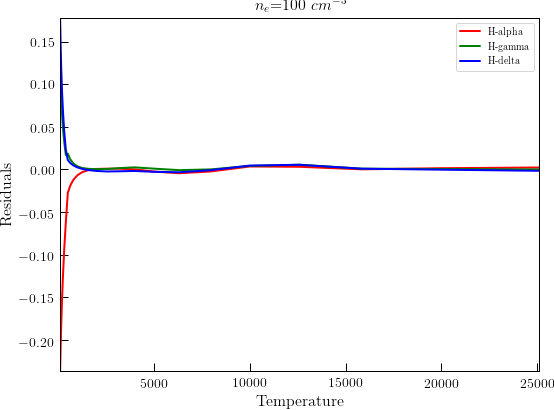

In [21]:
plt.subplots(figsize=(8,6))
plt.plot(temps, ((ha_dens/hb_dens)-old_ha_dens)/old_ha_dens, label='H-alpha', color='red')
plt.plot(temps, ((hg_dens/hb_dens)-old_hg_dens)/old_hg_dens, label='H-gamma', color='green')
plt.plot(temps, ((hd_dens/hb_dens)-old_hd_dens)/old_hd_dens, label='H-delta', color='blue')
plt.xlabel('Temperature')
plt.ylabel(r'Residuals')
plt.title(r'$n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/old_vs_new_hydrogen_emis_residuals_10.pdf')
plt.show()


# Try our own Cubic Extrapolation below n_e = 100

This table is the same as 'hydrogen_emissivity_short', but with the values at log(n_e)=0,1 removed

In [31]:
hydrogen_emis_noextrap = Table.read(path+'/tables/hydrogen_emissivity_noextrap', format='ascii', delimiter='\t')

## Extrapolate new emissivities, define old emissivities

In [91]:
# First find indices in hydrogen_emis_noextrap that correspond to each (Balmer) line
extrap_ha_idx = np.intersect1d(np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] == 2)[0])
extrap_hb_idx = np.intersect1d(np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] == 2)[0])
extrap_hg_idx = np.intersect1d(np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], np.where(hydrogen_emis_noextrap['Nl'] == 2)[0])
extrap_hd_idx = np.intersect1d(np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], np.where(hydrogen_emis_noextrap['Nl'] == 2)[0])

# Cubic interpolation
extrap_halpha = interp.RectBivariateSpline(np.linspace(2.0, 4.4, num=25), np.arange(2, 7), hydrogen_emis_noextrap[extrap_ha_idx]['emissivity'].reshape(25, 5), kx=3, ky=3)
extrap_hbeta = interp.RectBivariateSpline(np.linspace(2.0, 4.4, num=25), np.arange(2, 7), hydrogen_emis_noextrap[extrap_hb_idx]['emissivity'].reshape(25, 5), kx=3, ky=3)
extrap_hgamma = interp.RectBivariateSpline(np.linspace(2.0, 4.4, num=25), np.arange(2, 7), hydrogen_emis_noextrap[extrap_hg_idx]['emissivity'].reshape(25, 5), kx=3, ky=3)
extrap_hdelta = interp.RectBivariateSpline(np.linspace(2.0, 4.4, num=25), np.arange(2, 7), hydrogen_emis_noextrap[extrap_hd_idx]['emissivity'].reshape(25, 5), kx=3, ky=3)


In [240]:
print ('Range of T in Storey & Sochi hydrogen emissivities:', 10**2, 10**4.4)

Range of T in Storey & Sochi hydrogen emissivities: 100 25118.864315095823


In [ ]:
print ('Our cubic extrap:', extrap_halpha(np.log10(12500), np.log10(ne))[0][0] / extrap_hbeta(np.log10(12500), np.log10(ne))[0][0])
print ('NEBULAR linear extrap:', halpha(np.log10(12500), np.log10(ne))[0][0] / hbeta(np.log10(12500), np.log10(ne))[0][0])


## Calculate emissivity at desired n_e

In [ ]:
extrap_ha_dens = np.zeros(len(temps))
extrap_hb_dens = np.zeros(len(temps))
extrap_hg_dens = np.zeros(len(temps))
extrap_hd_dens = np.zeros(len(temps))

for i in range(len(temps)):
    extrap_ha_dens[i] = extrap_halpha(np.log10(temps[i]), np.log10(ne))[0][0]
    extrap_hb_dens[i] = extrap_hbeta(np.log10(temps[i]), np.log10(ne))[0][0]
    extrap_hg_dens[i] = extrap_hgamma(np.log10(temps[i]), np.log10(ne))[0][0]
    extrap_hd_dens[i] = extrap_hdelta(np.log10(temps[i]), np.log10(ne))[0][0]

## Plot Emissivity Comparisons

### H-alpha

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, ha_dens/hb_dens, label='H-alpha, NEBULAR', color='red') #NEBULAR does its own linear extrapolation
plt.plot(temps, old_ha_dens, 'o', label='H-alpha, H\&S 1987', color='red')
plt.plot(temps, extrap_ha_dens/extrap_hb_dens, label='H-alpha, cubic extrapolation', color='magenta', ls='--')

plt.xlabel('Temperature')
plt.ylabel(r'E($\lambda$)/E($H\beta$)')
plt.title(r'Emissivity+C/R comparisons, $n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/ha_extrap_10.pdf')
plt.show()

### H-gamma

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, hg_dens/hb_dens, label='H-gamma, NEBULAR', color='green')
plt.plot(temps, old_hg_dens, 'o', label='H-gamma, H\&S 1987', color='green')
plt.plot(temps, extrap_hg_dens/extrap_hb_dens, label='H-gamma, cubic extrapolation', color='lightgreen', ls='--')
plt.scatter(12500, extrap_hgamma(np.log10(12500), np.log10(ne))[0][0] / extrap_hbeta(np.log10(12500), np.log10(ne))[0][0], marker='*', color='orange')
plt.scatter(12500, hgamma(np.log10(12500), np.log10(ne))[0][0] / hbeta(np.log10(12500), np.log10(ne))[0][0], marker='^', color='magenta')
plt.xlabel('Temperature')
plt.ylabel(r'E($\lambda$)/E($H\beta$)')
plt.title(r'Emissivity+C/R comparisons, $n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_extrap_10.pdf')
plt.show()

### H-delta

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, hd_dens/hb_dens, label='H-delta, NEBULAR', color='blue')
plt.plot(temps, old_hd_dens, 'o', label='H-delta, H\&S 1987', color='blue')
plt.plot(temps, extrap_hd_dens/extrap_hb_dens, label='H-delta, cubic extrapolation', color='dodgerblue', ls='--')

plt.xlabel('Temperature')
plt.ylabel(r'E($\lambda$)/E($H\beta$)')
plt.title(r'Emissivity+C/R comparisons, $n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_extrap_10.pdf')
plt.show()

## Plot Residuals

### H-alpha

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, ((ha_dens/hb_dens)-old_ha_dens)/old_ha_dens, 'o', label='H-alpha, NEBULAR', color='red')
plt.plot(temps, ((extrap_ha_dens/extrap_hb_dens)-old_ha_dens)/old_ha_dens, label='H-alpha, cubic extrapolation', color='magenta')

plt.xlabel('Temperature')
plt.ylabel(r'Residuals')
plt.title(r'$n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_extrap_residuals_10.pdf')
plt.show()


### H-gamma

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, ((hg_dens/hb_dens)-old_hg_dens)/old_hg_dens, 'o', label='H-gamma, NEBULAR', color='green')
plt.plot(temps, ((extrap_hg_dens/extrap_hb_dens)-old_hg_dens)/old_hg_dens, label='H-gamma, cubic extrapolation', color='lightgreen')

plt.xlabel('Temperature')
plt.ylabel(r'Residuals')
plt.title(r'$n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_extrap_residuals_10.pdf')
plt.show()


### H-delta

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(temps, ((hd_dens/hb_dens)-old_hd_dens)/old_hd_dens, 'o', label='H-delta, NEBULAR', color='blue')
plt.plot(temps, ((extrap_hd_dens/extrap_hb_dens)-old_hd_dens)/old_hd_dens, label='H-delta, cubic extrapolation', color='dodgerblue')

plt.xlabel('Temperature')
plt.ylabel(r'Residuals')
plt.title(r'$n_{e}$='+str(ne)+'~$cm^{-3}$')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_extrap_residuals_10.pdf')
plt.show()


# Try Functional Form fit to emissivities at given n_e for PCA

## Our Functional Form

In [277]:
def functional_form(T, a, b, c, d):
    emis = ( a - (b * np.log(T)**2) + (c * np.log(T)) + (d / np.log(T)) ) * T**-1
    
    return emis

## AOS 2010 FF for H-beta (for comparison)

In [266]:
def aos2010_hbeta_emis(T):
    hbeta_emis = ( -2.6584e5 - (1420.9* np.log(T)**2) + \
                  (35546 * np.log(T)) + (6.5669e5 / np.log(T)) ) * T**-1
    return hbeta_emis

## Get indices in Hydrogen Emissivity Table corresponding to Balmer lines

Fitting only the temperature range ~5000-25000 K, for (1) a better fit in (2) the range we really care about

In [295]:
# Temperature array
temps = 10**np.linspace(3.7, 4.4, num=8) #np.linspace(5e3, 25e3, num=21)
print (temps)

[ 5011.87233627  6309.5734448   7943.28234724 10000.
 12589.25411794 15848.93192461 19952.62314969 25118.8643151 ]


In [268]:
from functools import reduce
ss2015_ha = hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]

ss2015_hb = hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                        np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                        np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0],
                        np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne))))]

## Test on H-alpha at one density first

In [269]:
popt, pcov = curve_fit(functional_form, temps, ss2015_ha)
testopt, testcov = curve_fit(functional_form, temps, ss2015_hb)

print(popt, testopt)

[-3.09795778e-20  2.01319941e-22  4.75313362e-21  7.18609981e-20] [-1.26011980e-20  8.88494537e-23  2.05842109e-21  2.22402947e-20]


In [270]:
# Old Hummer & Storey 1987 emissivities, relative to H-beta, including C/R, for comparison
old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


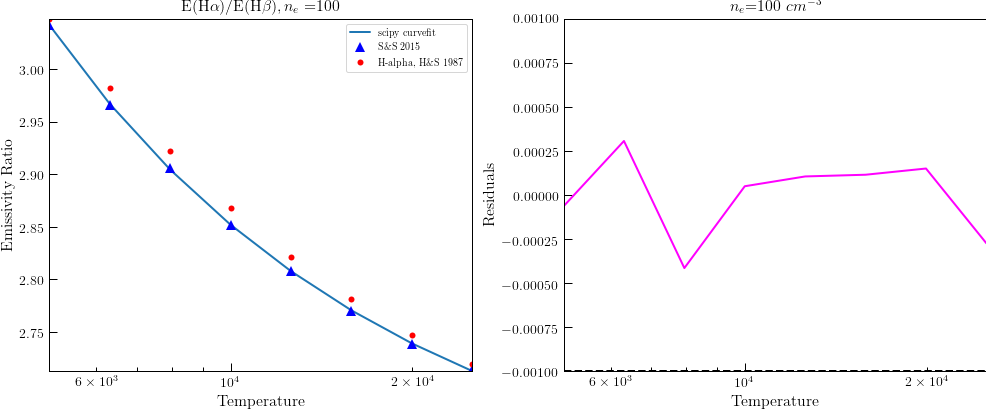

In [271]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(temps, functional_form(temps, *popt)/functional_form(temps, *testopt), label='scipy curvefit')
ax1.plot(temps, ss2015_ha/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
ax1.plot(temps, old_ha_dens, 'o', label='H-alpha, H\&S 1987', color='red')
ax1.set_xscale('log')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_xlabel('Temperature')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta), n_{e}=$'+str(ne))
ax1.legend()
ax2.plot(temps, ((functional_form(temps, *popt)/functional_form(temps, *testopt)-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb)), label='scipy curvefit', color='magenta')
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel(r'Residuals')
ax2.set_title(r'$n_{e}$='+str(ne)+'~$cm^{-3}$')
#f.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/funcform_Ha_abcdef_log.pdf', overwrite=True)
f.show()

## Now test on multiple Balmer lines at varying densities

### Density array

These densities correspond to those given as data points from the Storey & Sochi 2015 hydrogen emissivities

In [272]:
ne_array = 10**np.array([2,3,4,5,6])

print (ne_array, len(ne_array))

[    100    1000   10000  100000 1000000] 5


### scipy's curvefit coefficients

In [290]:
ha_a_coeff = np.zeros(len(ne_array))
ha_b_coeff = np.zeros(len(ne_array))
ha_c_coeff = np.zeros(len(ne_array))
ha_d_coeff = np.zeros(len(ne_array))

hb_a_coeff = np.zeros(len(ne_array))
hb_b_coeff = np.zeros(len(ne_array))
hb_c_coeff = np.zeros(len(ne_array))
hb_d_coeff = np.zeros(len(ne_array))

hg_a_coeff = np.zeros(len(ne_array))
hg_b_coeff = np.zeros(len(ne_array))
hg_c_coeff = np.zeros(len(ne_array))
hg_d_coeff = np.zeros(len(ne_array))

hd_a_coeff = np.zeros(len(ne_array))
hd_b_coeff = np.zeros(len(ne_array))
hd_c_coeff = np.zeros(len(ne_array))
hd_d_coeff = np.zeros(len(ne_array))

h8_a_coeff = np.zeros(len(ne_array))
h8_b_coeff = np.zeros(len(ne_array))
h8_c_coeff = np.zeros(len(ne_array))
h8_d_coeff = np.zeros(len(ne_array))

pg_a_coeff = np.zeros(len(ne_array))
pg_b_coeff = np.zeros(len(ne_array))
pg_c_coeff = np.zeros(len(ne_array))
pg_d_coeff = np.zeros(len(ne_array))

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


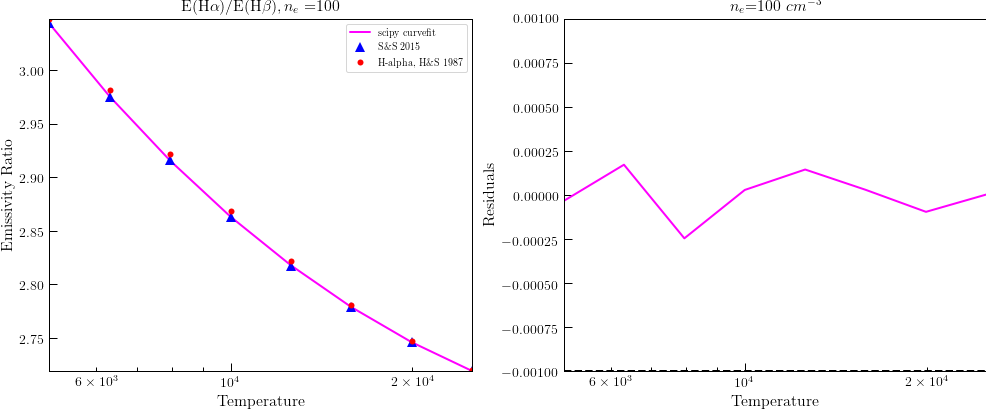

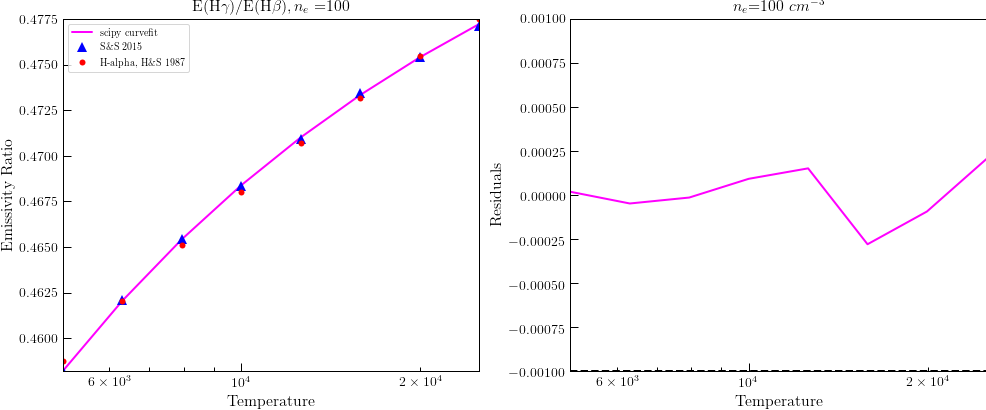

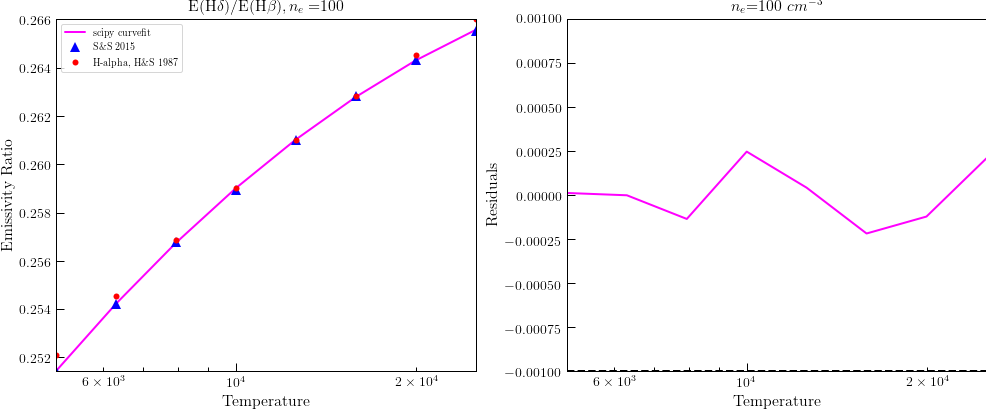

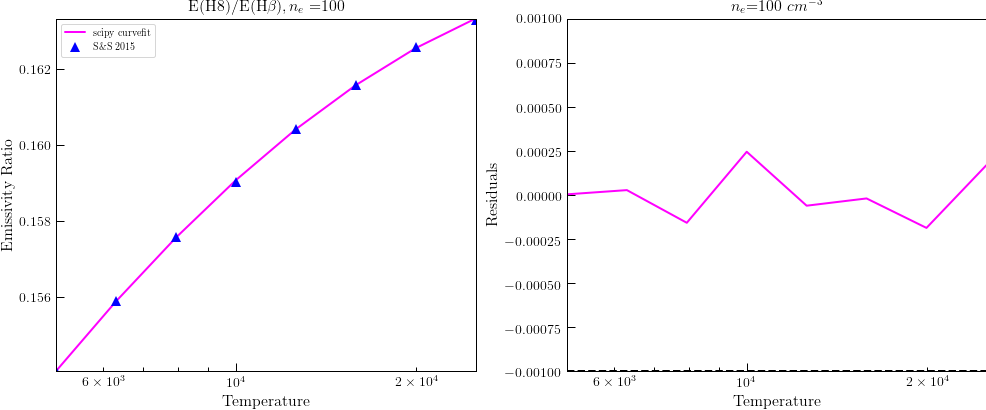

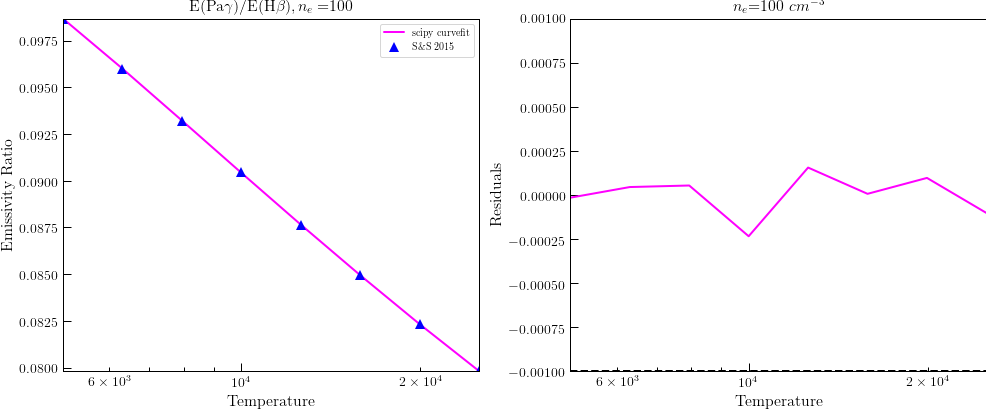

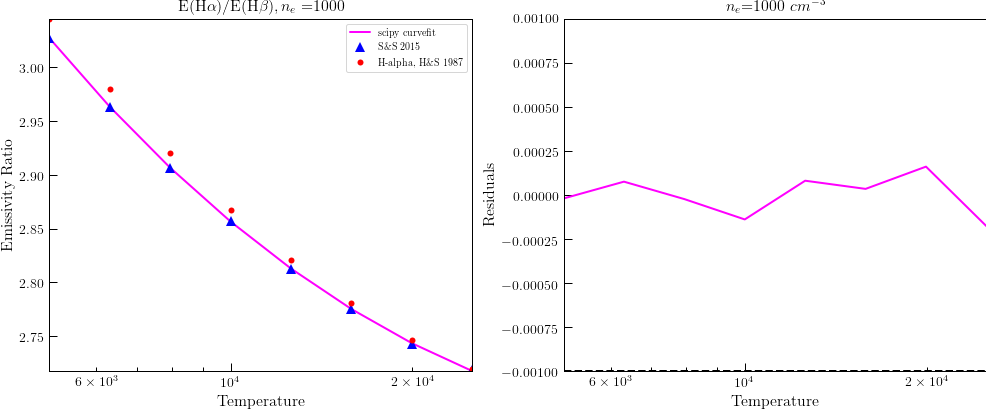

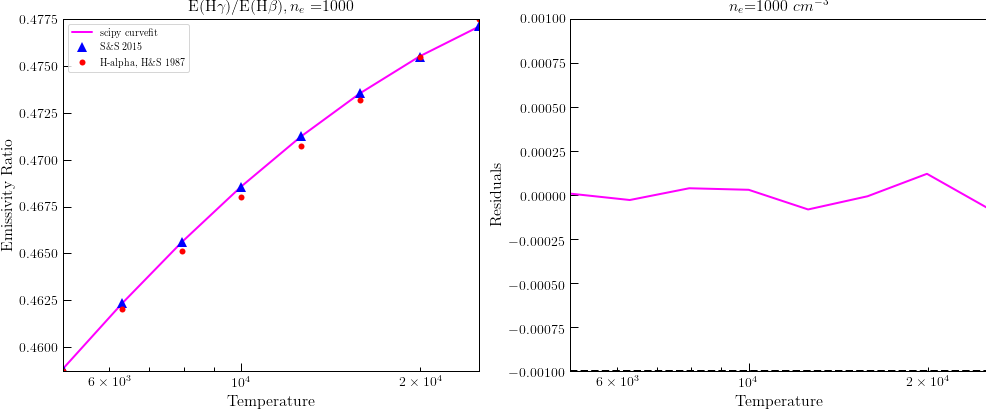

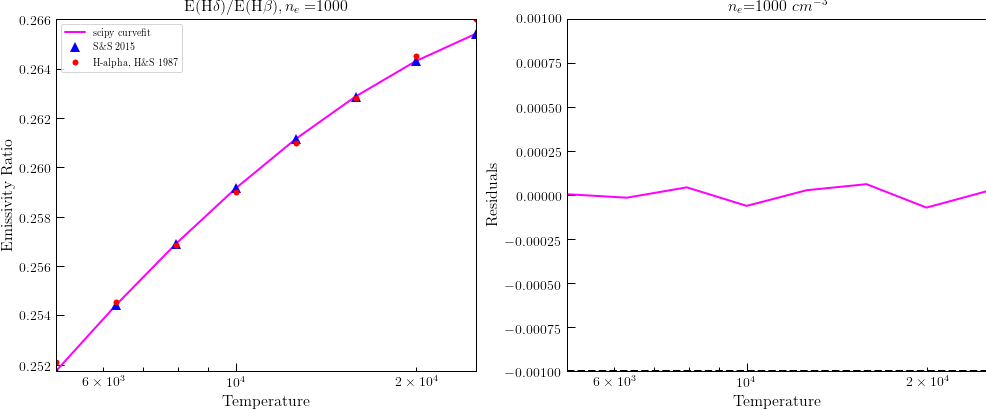

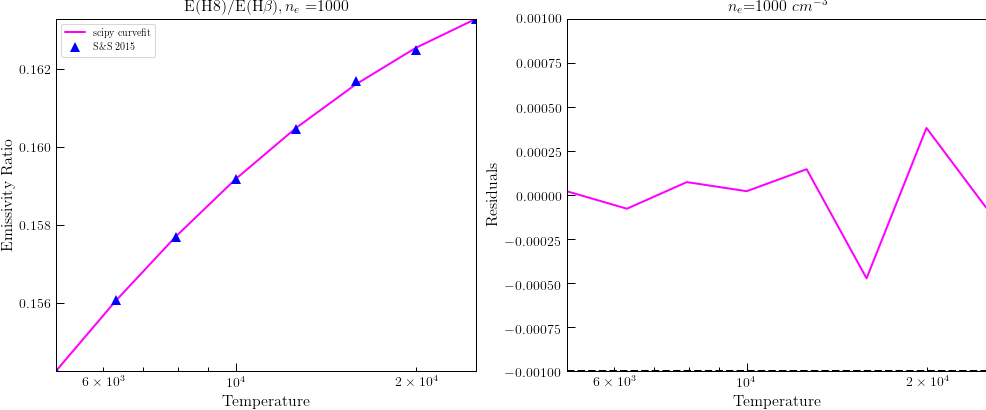

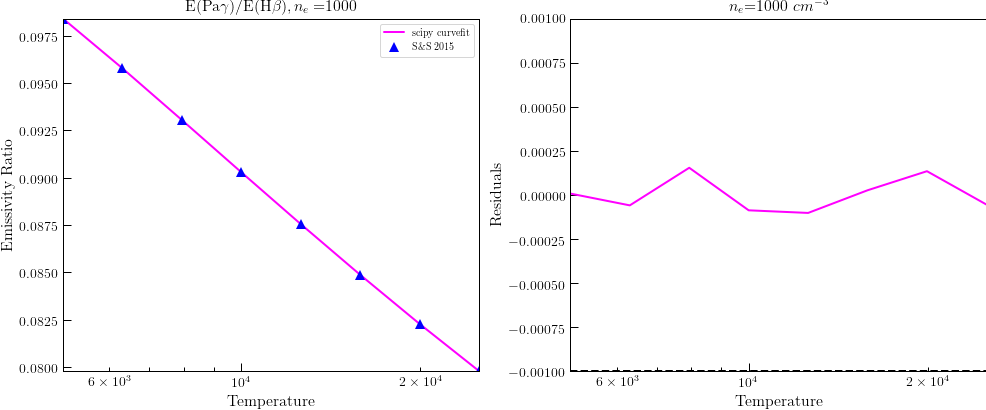

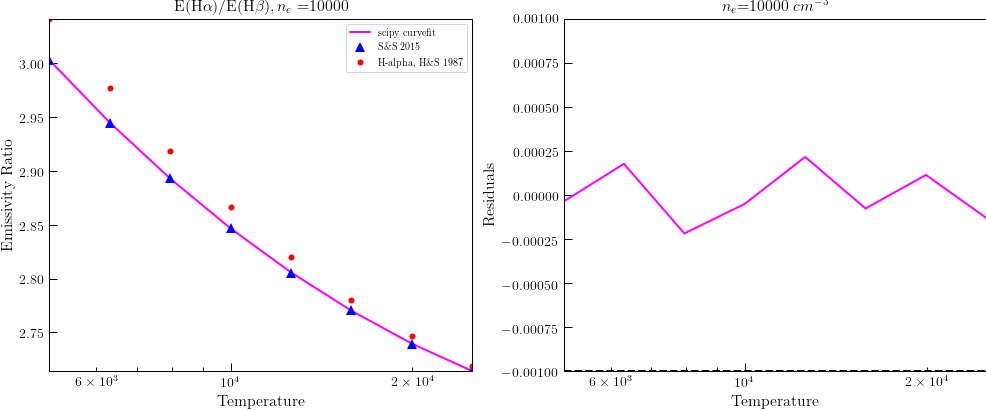

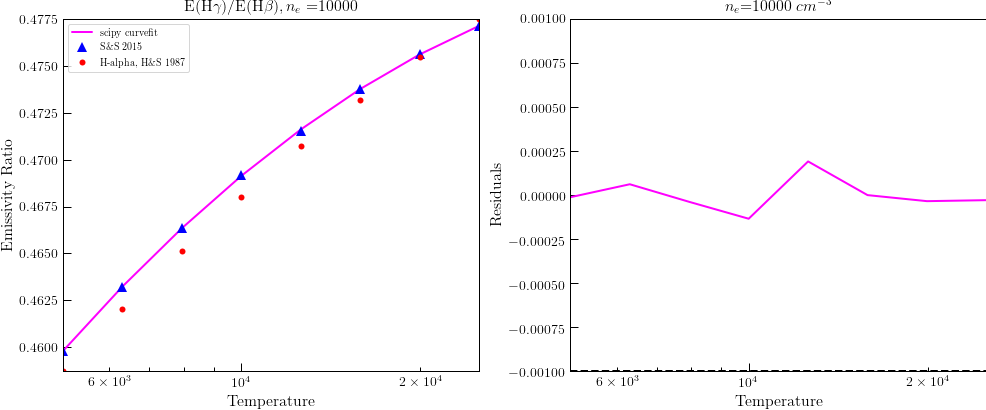

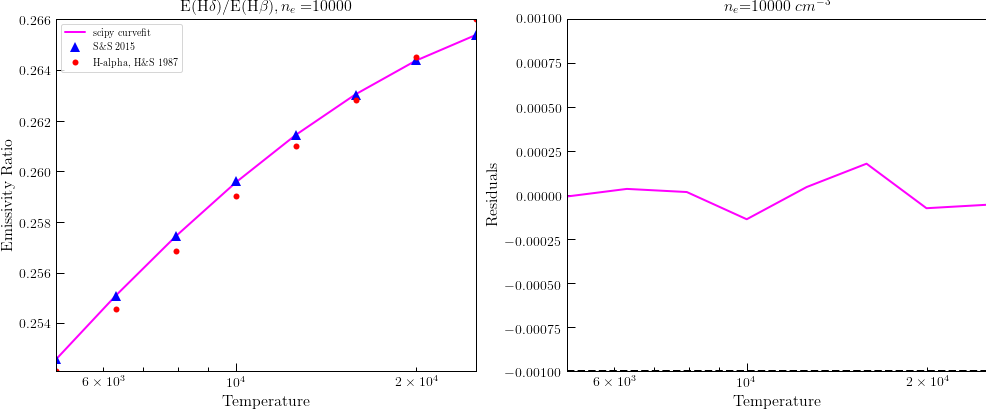

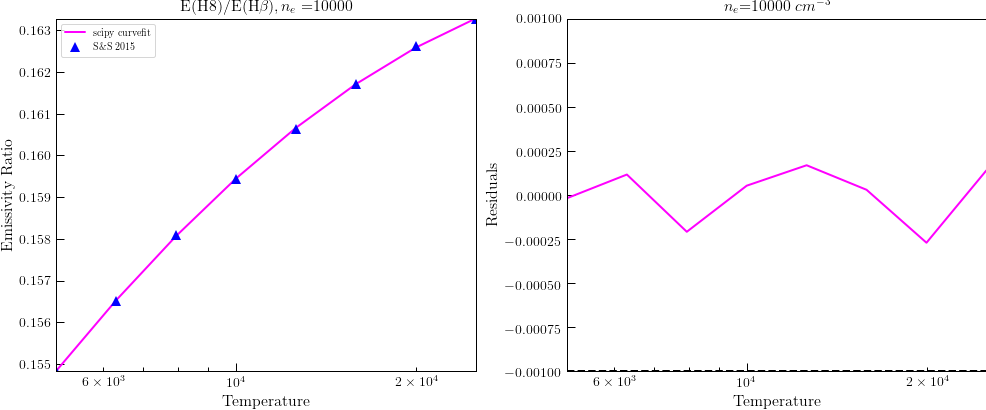

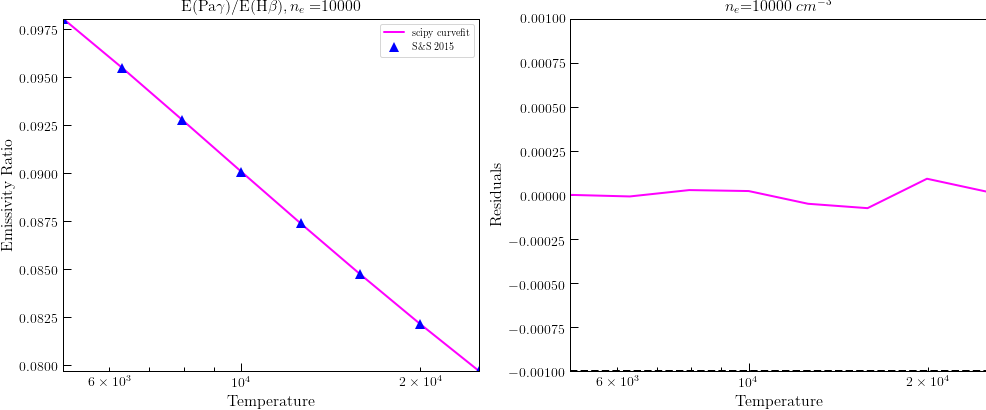

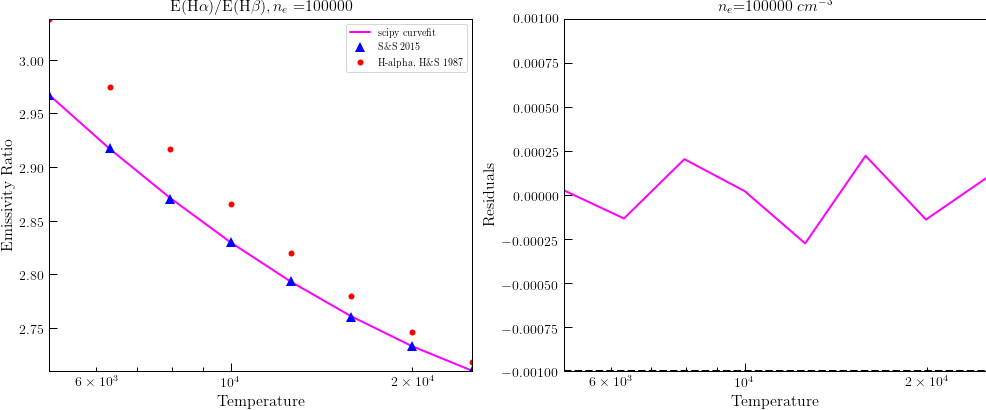

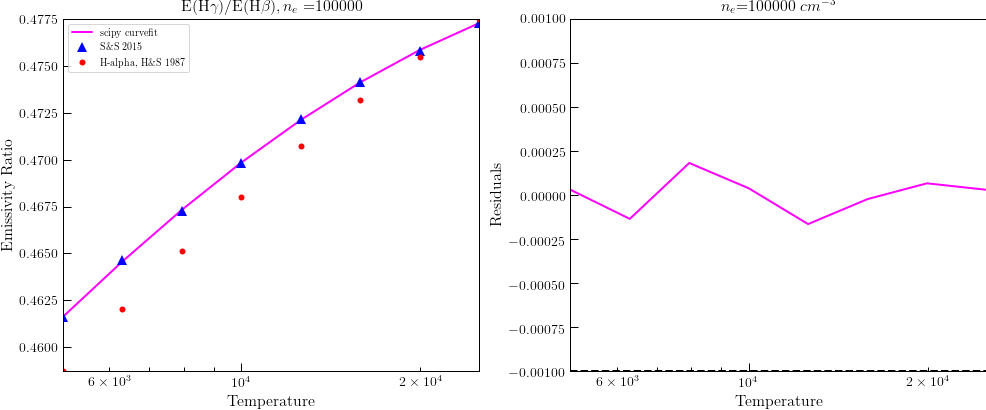

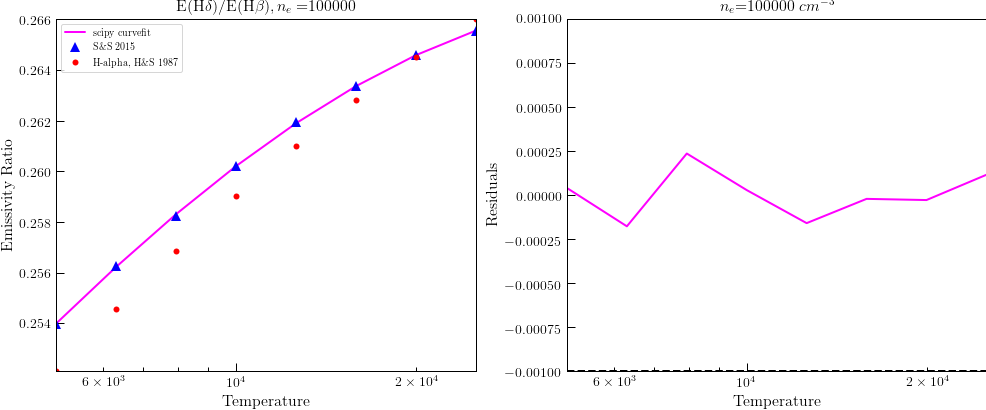

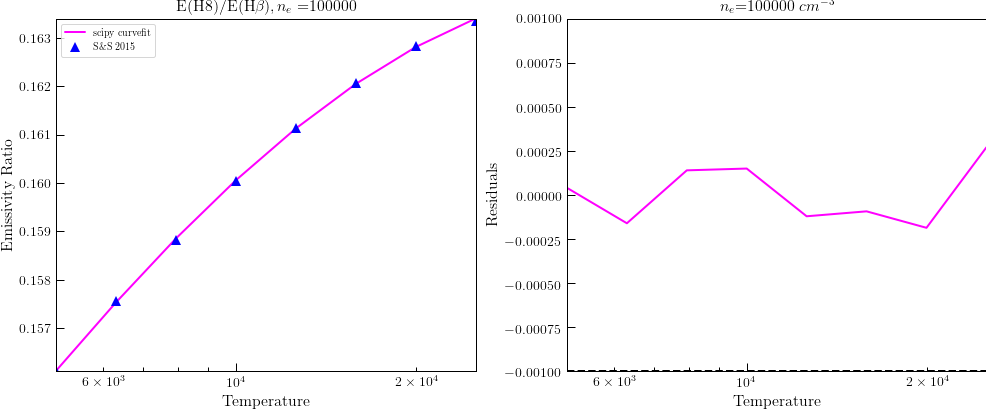

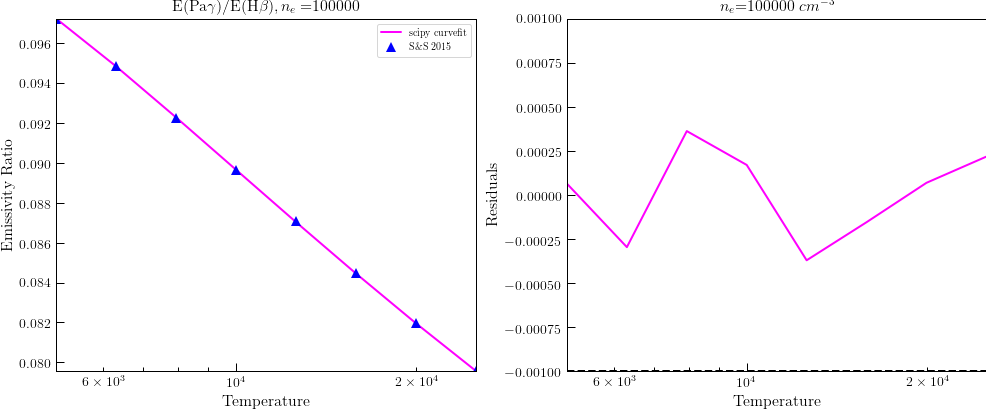

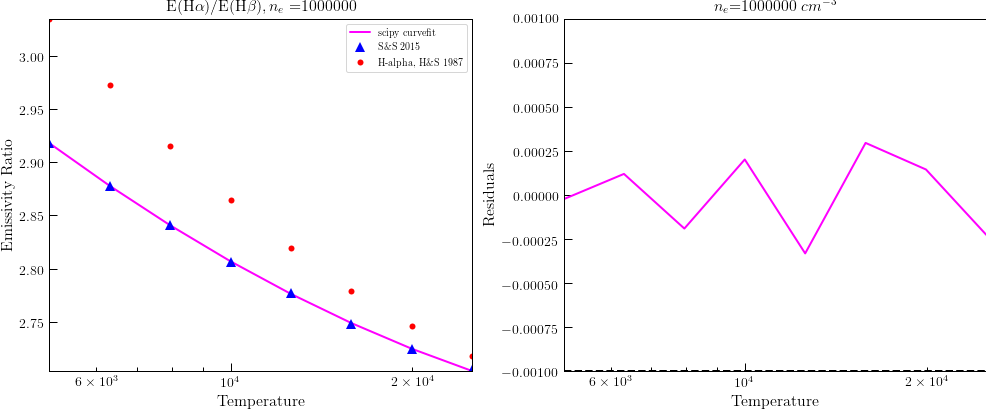

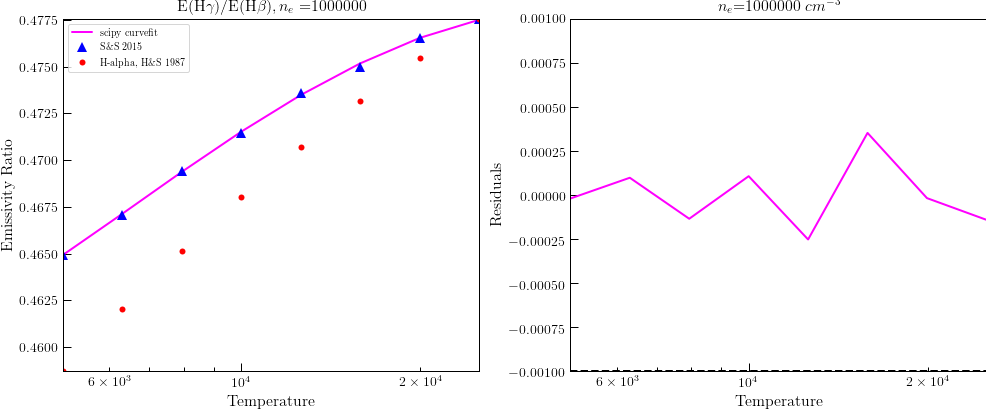

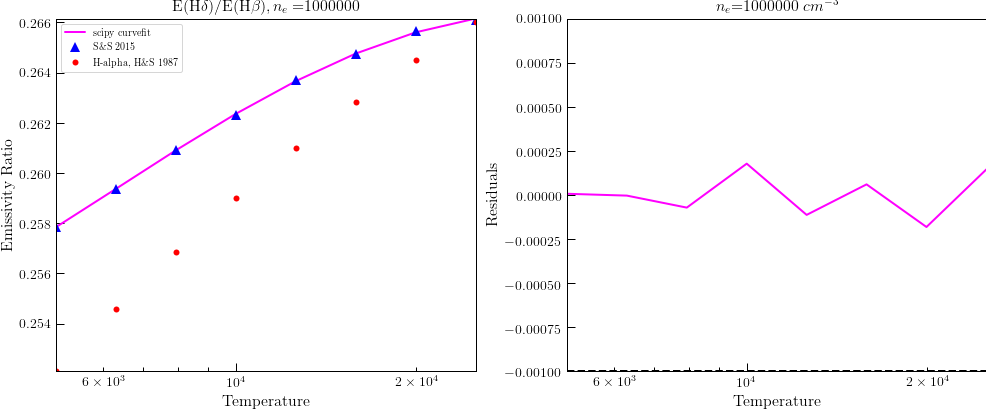

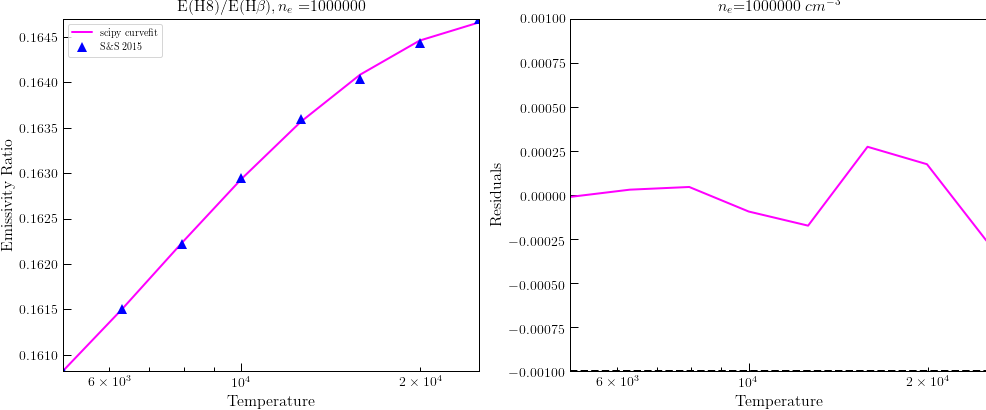

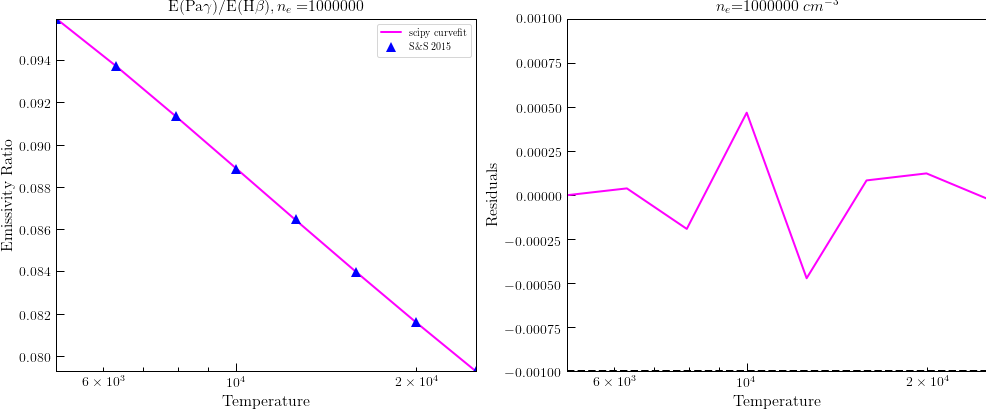

In [292]:
# Open .pdf to save emissivity and residual plots in
ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_curvefits_residuals.pdf')
hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_curvefits_residuals.pdf')
hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_curvefits_residuals.pdf')
h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/h8_curvefits_residuals.pdf')
pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/pg_curvefits_residuals.pdf')
for dens in range(len(ne_array)):
    # Find indices in hydrogen_emissivity_noextrap that correspond to Balmer transitions of interest
    # and pull the emissivity values at those indices
    ss2015_ha = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hd = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_h8 = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 7)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_pg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]

    # Fit a functional form to our new extrapolated emissivities
    popta, pcova = curve_fit(functional_form, temps, ss2015_ha)
    ha_a_coeff[dens] = popta[0]
    ha_b_coeff[dens] = popta[1]
    ha_c_coeff[dens] = popta[2]
    ha_d_coeff[dens] = popta[3]
     
    poptb, pcovb = curve_fit(functional_form, temps, ss2015_hb)
    hb_a_coeff[dens] = poptb[0]
    hb_b_coeff[dens] = poptb[1]
    hb_c_coeff[dens] = poptb[2]
    hb_d_coeff[dens] = poptb[3]
    
    poptg, pcovg = curve_fit(functional_form, temps, ss2015_hg)
    hg_a_coeff[dens] = poptg[0]
    hg_b_coeff[dens] = poptg[1]
    hg_c_coeff[dens] = poptg[2]
    hg_d_coeff[dens] = poptg[3]
    
    poptd, pcovd = curve_fit(functional_form, temps, ss2015_hd)
    hd_a_coeff[dens] = poptd[0]
    hd_b_coeff[dens] = poptd[1]
    hd_c_coeff[dens] = poptd[2]
    hd_d_coeff[dens] = poptd[3]
    
    popt8, pcov8 = curve_fit(functional_form, temps, ss2015_h8)
    h8_a_coeff[dens] = popt8[0]
    h8_b_coeff[dens] = popt8[1]
    h8_c_coeff[dens] = popt8[2]
    h8_d_coeff[dens] = popt8[3]
    
    poptpg, pcovpg = curve_fit(functional_form, temps, ss2015_pg)
    pg_a_coeff[dens] = poptpg[0]
    pg_b_coeff[dens] = poptpg[1]
    pg_c_coeff[dens] = poptpg[2]
    pg_d_coeff[dens] = poptpg[3]
    
    # Calculate the old H&S 1987 emissivities at this density for comparison
    old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne_array[dens])

    # Plot!
    # H-alpha
    ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *popta)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_ha/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_ha_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\alpha$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *popta)/functional_form(temps, *poptb)-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    ha_pdf.savefig(ha_f)
    
    # H-gamma
    hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptg)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_hg_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptg)/functional_form(temps, *poptb)-(ss2015_hg/ss2015_hb))/(ss2015_hg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    hg_pdf.savefig(hg_f)
    
    # H-delta
    hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptd)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hd/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_hd_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\delta$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptd)/functional_form(temps, *poptb)-(ss2015_hd/ss2015_hb))/(ss2015_hd/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    hd_pdf.savefig(hd_f)
    
    # H8
    h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *popt8)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_h8/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H8)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *popt8)/functional_form(temps, *poptb)-(ss2015_h8/ss2015_hb))/(ss2015_h8/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    h8_pdf.savefig(h8_f)
    
    # Pa-gamma
    pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptpg)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_pg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptpg)/functional_form(temps, *poptb)-(ss2015_pg/ss2015_hb))/(ss2015_pg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    pg_pdf.savefig(pg_f)
        
# Close pdfs
ha_pdf.close()
hg_pdf.close()
hd_pdf.close()
h8_pdf.close()
pg_pdf.close()
# Show whichever plot we want
hd_f.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


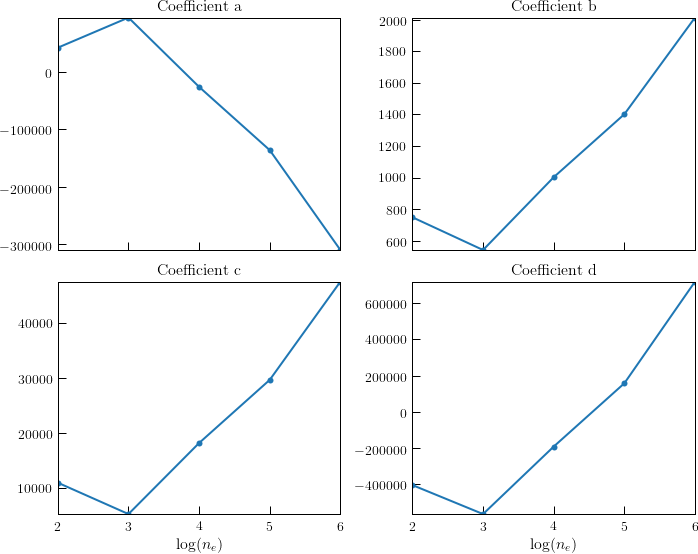

In [294]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(10,8))
ax1.plot(np.log10(ne_array), ha_a_coeff, marker='o')
ax1.set_title('Coefficient a')
ax2.plot(np.log10(ne_array), ha_b_coeff, marker='o')
ax2.set_title('Coefficient b')
ax3.plot(np.log10(ne_array), ha_c_coeff, marker='o')
ax3.set_xlabel(r'log($n_{e}$)')
ax3.set_title('Coefficient c')
ax4.plot(np.log10(ne_array), ha_d_coeff, marker='o')
ax4.set_xlabel(r'log($n_{e}$)')
ax4.set_title('Coefficient d')
#f.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_coefficients.pdf', overwrite=True)
f.show()

## 3D Surface

In [ ]:
temp_array = np.logspace(2.6, 4.7, num=1000)
dens_array = np.logspace(2, 8, num=1000)

t, d = np.meshgrid(temp_array, dens_array)
ha_emis_grid = extrap_halpha(np.log10(temp_array), np.log10(dens_array)) # RectBivariateSpline

In [ ]:
# Test plot of H-alpha emissivity grid
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(t, np.log10(d), ha_emis_grid*1e25, color='black', alpha=0.2)
ax.scatter(10**hydrogen_emis_noextrap['log(T)'], hydrogen_emis_noextrap['log(ne)'], 1e25*hydrogen_emis_noextrap['emissivity'], '.')

for spine in ax.spines.values():
    spine.set_visible(False)
    
#ax.set_xlim(10**2.6, 10**4.7)
#ax.set_zlim(0, 5)
ax.set_xlabel('Temperature')
ax.set_ylabel('log(Density)')
ax.set_zlabel('Emissivity ($\\times\,10^{25}$)')
#ax.set_title('H-alpha')
#fig.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_extrapolation.pdf', overwrite=True)
fig.show()